In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean , get_MOI, get_MOI_2D 
from invariance_functions import degree_of_freedom, get_GPR_model_2D, get_SHM_data_2D, get_double_pendulum_data, evaluate_model_future_2D, evaluate_model_grid_2D, SHM_dynamics1_2D, SHM_dynamics2_2D, get_GPR_model_GD_2D
from local_invariance_kernels import  get_polynomial_local_invariance_2D, get_SHM_local_invariance_2D, get_double_pendulum_local_invariance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [5]:

mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 5
max_v = 0.5
n_train = 3
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_SHM_data_2D(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch


[ 4.48583742 -4.4799205  -2.0866684 ]
[-3.00042059  2.45871457 -2.34582828]
[-0.22533987 -0.28816429  0.2492926 ]
[0.17394293 0.35574992 0.05956767]


In [6]:

#scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
#scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
scalerX = MinMaxScaler((-1,1)).fit(data2[0])
scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)
scalers = (scalerX, scalerY)
time_setting = (testing_time, time_step)
dynamics = (SHM_dynamics1_2D, SHM_dynamics2_2D)
jitter = 1e-5

#joblib.dump(scalerX, 'shm_2d/scalerX.gz')
#joblib.dump(scalerY, 'shm_2d/scalerY.gz')

In [15]:

eva_future_moi = []
eva_future_known = []
eva_future_learnt = []

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())
try:
    n_neighbours = 30
    print("known")
    kernel_known = get_SHM_local_invariance_2D(0.1, 1, n_neighbours, jitter) #switch
    known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
    print(known.log_marginal_likelihood().numpy())

    polynomial_degree = 1
    print("learnt")
#    X, Y = data
    kernel = get_polynomial_local_invariance_2D(0.1, 1, n_neighbours, jitter, polynomial_degree) 
    model = get_GPR_model_2D(kernel, mean, data, iterations=1000)
    print(model.log_marginal_likelihood().numpy())
#    model = get_GPR_model_2D(kernel, mean, data, iterations=10000, old_kernel=kernel_known)
#    ckpt = tf.train.Checkpoint(model=model)
#    manager = tf.train.CheckpointManager(ckpt, "shm_2d", max_to_keep=3)
#    model = get_GPR_model_GD_2D(model=model, iterations=10000, lr=0.001, manager=manager)
#    print(model.log_marginal_likelihood().numpy())
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi
367.3627990484882
known
429.586968431828
learnt
409.9478594096556


In [16]:

def energy(X):
    return 0.5*(tf.square(X[:,0])+tf.square(X[:,1])+tf.square(X[:,2])+tf.square(X[:,3]))
for i in range(1):
    print(i)
    test_starting_position1 = np.random.uniform(-max_x, max_x)
    test_starting_position2 = np.random.uniform(-max_x, max_x)
    test_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5)
    test_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5)
    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
    print(test_starting)
    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_moi.append(evaluate_moi[0])
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_known.append(evaluate_known[0])
    evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_learnt.append(evaluate_learnt[0])
    print(evaluate_known[0])
    plt.plot(evaluate_learnt[5], label="true")
    plt.plot(evaluate_moi[6], label="RBF")
    plt.plot(evaluate_known[6], label="known")
    plt.plot(evaluate_learnt[6], label="learnt")
    plt.legend()

0
(4.714825658185882, 3.189952348775824, -0.06255522172328676, -0.6753695471598586)


KeyboardInterrupt: 

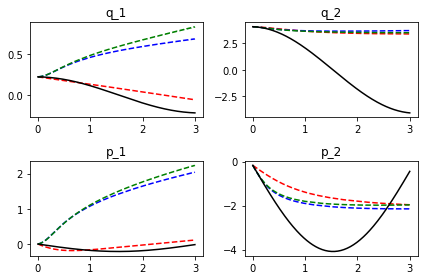

In [9]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0][0].plot(t,evaluate_known[1][:,0], "--", label="known", color="blue")
axs[0][0].plot(t,evaluate_learnt[1][:,0], "--", label="learnt", color="green")
axs[0][0].plot(t,evaluate_known[4][:,0],label="ground truth", color="black")
axs[0][0].set_title("q_1")
#axs[0][0].legend()

axs[0][1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[0][1].plot(t,evaluate_known[1][:,1], "--", label="known", color="blue")
axs[0][1].plot(t,evaluate_learnt[1][:,1], "--", label="learnt", color="green")
axs[0][1].plot(t,evaluate_known[4][:,1],label="ground truth", color="black")
axs[0][1].set_title("q_2")
#axs[0][1].legend()

axs[1][0].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[1][0].plot(t,evaluate_known[1][:,2], "--", label="known", color="blue")
axs[1][0].plot(t,evaluate_learnt[1][:,2], "--", label="learnt", color="green")
axs[1][0].plot(t,evaluate_known[4][:,2],label="ground truth", color="black")
axs[1][0].set_title("p_1")
#axs[1][0].legend()

axs[1][1].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[1][1].plot(t,evaluate_known[1][:,3], "--", label="known", color="blue")
axs[1][1].plot(t,evaluate_learnt[1][:,3], "--", label="learnt", color="green")
axs[1][1].plot(t,evaluate_known[4][:,3],label="ground truth", color="black")
axs[1][1].set_title("p_2")
#axs[1][1].legend()

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.tight_layout()


In [11]:
evaluate_known[0]
evaluate_moi[0]

5.487705831171902